<a href="https://colab.research.google.com/github/xenagarage/VolcanoClassification/blob/main/VolcanoClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Volcano Classification

**Case Definition** ➡️
Given surface images, build a model that finds Volcano pattern, returns a classification result of whether image has a volcano in it or not.


**Input** ➡️
Labeled radar images

**Expected Output** ➡️
Classified target label (for first case Yes/No Volcano answer, for the second scenario type of the Volcano)

# Imports and getting the data

In [ ]:
# updated driver control
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec 11 18:35:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# ram control
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import keras.utils as image
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

from sklearn.utils import resample
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold
from pprint import pprint
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# mounting drive to pull dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip image datasets
!unzip "/content/drive/MyDrive/datasets/train_images.zip" -d "/content/"
!unzip "/content/drive/MyDrive/datasets/test_images.zip" -d "/content/"

In [ ]:
# define paths
train_images_path = '/content/train_images/'
test_images_path = '/content/test_images/'

In [ ]:
# transform labels to pandas dataframes
train_labels = pd.read_csv('/content/drive/MyDrive/datasets/train_labels.csv')
test_labels = pd.read_csv('/content/drive/MyDrive/datasets/test_labels.csv')

# Data Exploration and Analysis (EDA)



This section includes getting to know the type of data we work on, as well as repairing some issues on the dataset, by following Explorary Data Analysis (EDA) steps

What does our **labels** look like?

In [ ]:
# show first 5 data example
print(train_labels.head())
print()

print(test_labels.head())

   Volcano?  Type  Radius  Number Volcanoes
0         1   3.0   17.46               1.0
1         0   NaN     NaN               NaN
2         0   NaN     NaN               NaN
3         0   NaN     NaN               NaN
4         0   NaN     NaN               NaN

   Volcano?  Type  Radius  Number Volcanoes
0         0   NaN     NaN               NaN
1         0   NaN     NaN               NaN
2         1   1.0   17.00               1.0
3         0   NaN     NaN               NaN
4         1   3.0   15.13               1.0


We have 4 labels, first label will be our target for Model 1 that answers the Binary Classification Case ➡️ are there a volcano on the image question

The second label type will be target for Model 2, what is the type of the volcano

When our "Volcano exists?" target feature is 0 (doesn't exists), the other features are not getting filled.

In [ ]:
train_labels.describe()

,Volcano?,Type,Radius,Number Volcanoes
count,7000.000000,1000.000000,1000.000000,1000.000000
mean,0.142857,2.965000,16.257650,1.236000
std,0.349952,0.984248,11.632887,0.553724
min,0.000000,1.000000,1.000000,1.000000
25%,0.000000,2.000000,5.830000,1.000000
50%,0.000000,3.000000,14.870000,1.000000
75%,0.000000,4.000000,23.555001,1.000000
max,1.000000,4.000000,87.660000,5.000000


In [ ]:
# change label names into less complex

train_labels = train_labels.rename({'Volcano?': 'volcano', 'Type': 'type', 'Radius': 'radius', 'Number Volcanoes': 'nvolcano'}, axis=1)
print(list(train_labels.columns))

['volcano', 'type', 'radius', 'nvolcano']


In [ ]:
test_labels

,Volcano?,Type,Radius,Number Volcanoes
0,0,NaN,NaN,NaN
1,0,NaN,NaN,NaN
2,1,1.0,17.00,1.0
3,0,NaN,NaN,NaN
4,1,3.0,15.13,1.0
...,...,...,...,...
2729,0,NaN,NaN,NaN
2730,0,NaN,NaN,NaN
2731,0,NaN,NaN,NaN
2732,0,NaN,NaN,NaN


In [ ]:
# change label names into less complex

test_labels = test_labels.rename({'Volcano?': 'volcano', 'Type': 'type', 'Radius': 'radius', 'Number Volcanoes': 'nvolcano'}, axis=1)
print(list(test_labels.columns))

['volcano', 'type', 'radius', 'nvolcano']


Okay what does our **image** data looks like?

Changing the look of images in the following step to make it 1 dimension

In [ ]:
def get_images_as_df(file_name_list):
  images = []
  for file_name in file_name_list:
    img = image.load_img(
        file_name,
        # target_size=(110,110,1), 
        color_mode = "grayscale")
    img = image.img_to_array(img).astype(int)
    images.append(np.reshape(img, -1))

  return pd.DataFrame.from_records(np.array(images))

In [ ]:
# show how our train images look like now
train_image_names = [train_images_path + name for name in os.listdir(train_images_path)]
train_images = get_images_as_df(train_image_names)
train_images.head()

,0,1,2,3,4,5,6,7,8,9,...,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
0,97,96,101,97,94,98,96,100,99,77,...,127,122,134,148,144,142,133,123,132,133
1,100,106,94,90,82,82,81,81,78,64,...,89,73,83,98,91,84,94,80,87,98
2,89,102,107,98,96,90,86,96,98,71,...,133,120,110,131,132,117,106,98,92,93
3,121,124,126,123,114,106,92,92,107,114,...,109,111,115,117,113,106,96,112,130,130
4,104,111,111,118,102,100,82,80,78,95,...,119,137,93,117,123,108,106,115,97,127


In [ ]:
# show how our test images look like now
test_image_names = [test_images_path + name for name in os.listdir(test_images_path)]
test_images = get_images_as_df(test_image_names)
test_images.head()

,0,1,2,3,4,5,6,7,8,9,...,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
0,94,100,109,109,103,104,108,107,97,104,...,104,98,105,106,100,99,105,117,121,121
1,97,120,123,104,115,125,120,118,116,121,...,94,119,108,112,118,129,110,125,122,124
2,126,132,126,114,129,113,120,118,124,115,...,126,136,130,131,137,135,147,162,152,134
3,106,112,120,105,99,98,96,117,113,105,...,121,124,124,132,129,113,116,128,121,124
4,92,114,127,118,94,91,100,93,106,113,...,111,85,101,121,122,101,98,114,119,122


**Data shape**?

In [ ]:
print(f"train images: {train_images.shape}")
print(f"train labels: {train_labels.shape}")
print(f"test images: {test_images.shape}")
print(f"test labels: {test_labels.shape}")

train images: (7000, 12100)
train labels: (7000, 4)
test images: (2734, 12100)
test labels: (2734, 4)


In [ ]:
# train_images.to_csv('train_images.csv', index=False)
# test_images.to_csv('test_images.csv', index=False)

What is our data distribution on each label?

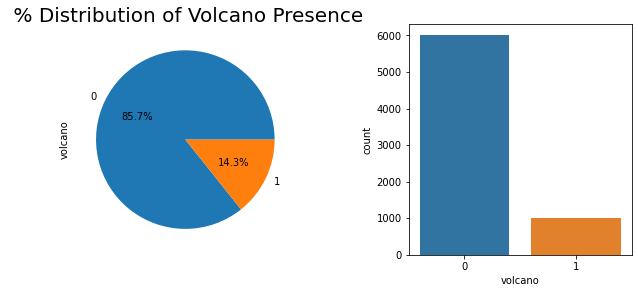

In [ ]:
plt.figure(figsize=(10,4))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9,
                      wspace=0.5, hspace=0.2)
plt.subplot(1, 2, 1)
plt.title(' % Distribution of Volcano Presence',fontsize = 20)
train_labels['volcano'].value_counts().plot.pie(autopct="%1.1f%%")

plt.subplot(1, 2, 2)
plt.rcParams['figure.figsize'] = (5, 5)
sns.countplot(train_labels['volcano'])

plt.show()

In [ ]:
train_labels.volcano.value_counts()

0    6000
1    1000
Name: volcano, dtype: int64

Our examples are piled on No Volcano Exists mostly, so I might consider sampling/augmenting new examples in order to supply more Volcano example.

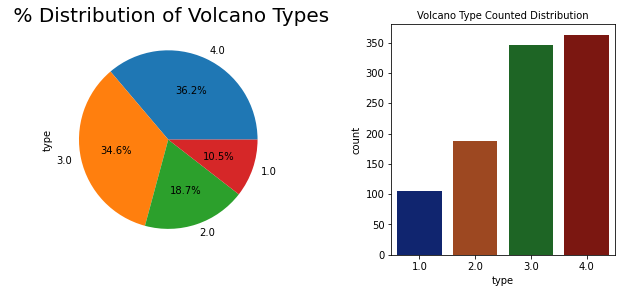

In [ ]:
plt.figure(figsize=(10,4))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9,
                      wspace=0.5, hspace=0.2)
plt.subplot(1, 2, 1)
plt.title(' % Distribution of Volcano Types',fontsize = 20)
train_labels['type'].value_counts().plot.pie(autopct="%1.1f%%")

plt.subplot(1, 2, 2)
sns.countplot(train_labels['type'], palette = 'dark')
plt.title('Volcano Type Counted Distribution', fontsize = 10)

plt.show()

In [ ]:
train_labels.type.value_counts()

4.0    362
3.0    346
2.0    187
1.0    105
Name: type, dtype: int64

Type 3 and 4 are dominating

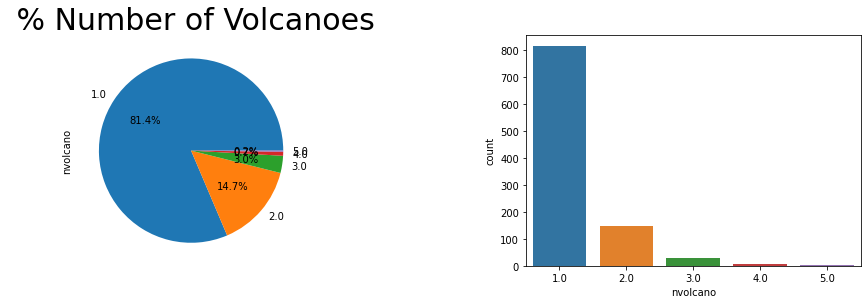

In [ ]:
plt.figure(figsize=(15,4))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9,
                      wspace=0.5, hspace=0.2)
plt.subplot(1, 2, 1)
plt.title(' % Number of Volcanoes',fontsize = 30)
train_labels['nvolcano'].value_counts().plot.pie(autopct="%1.1f%%")

plt.subplot(1, 2, 2)
plt.rcParams['figure.figsize'] = (5, 5)
sns.countplot(train_labels['nvolcano'])

plt.show()

In [ ]:
train_labels.nvolcano.value_counts()

1.0    814
2.0    147
3.0     30
4.0      7
5.0      2
Name: nvolcano, dtype: int64

We could say that there's an imbalance and the data is piled mostly on 1 following with 2 volcano presence.

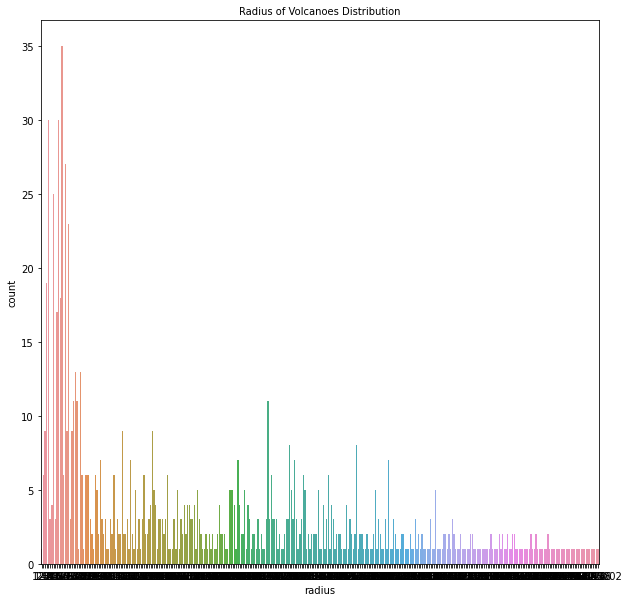

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
sns.countplot(train_labels['radius'])
plt.title('Radius of Volcanoes Distribution', fontsize = 10)
plt.show()

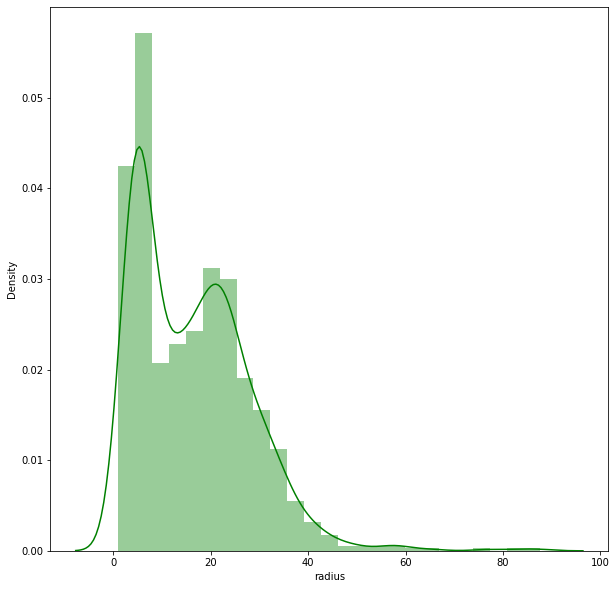

In [ ]:
sns.distplot(train_labels.radius , color = 'green')

Radius looks left skewed but there are multiple peaks in the data

In [ ]:
train_labels.radius.value_counts()

5.000000     35
2.830000     30
4.240000     30
5.390000     27
3.610000     25
             ..
49.770000     1
32.650002     1
16.969999     1
31.139999     1
27.020000     1
Name: radius, Length: 333, dtype: int64

Lucky that we don't specificly work with Radius :) 

Are there any **duplicated values**?

In [ ]:
train_labels.duplicated().sum()

6436

**Missing values?**

In [ ]:
train_labels.isna().sum()

volcano        0
type        6000
radius      6000
nvolcano    6000
dtype: int64

The 6000 No Volcano 0 class

In [ ]:
train_labels.isna().sum().sum()

18000

This information will be considered on Type Classification Model

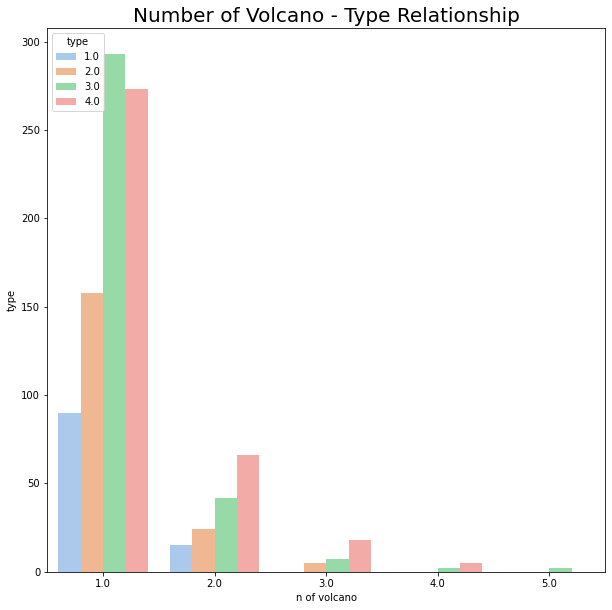

In [ ]:
comparing = sns.countplot('nvolcano',hue='type', data=train_labels, palette='pastel')
comparing.axes.set_title('Number of Volcano - Type Relationship',fontsize=20)
comparing.set_xlabel("n of volcano",fontsize=10)
comparing.set_ylabel("type",fontsize=10)
plt.show()

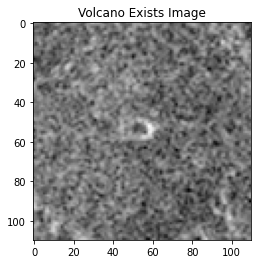

In [ ]:
# examples of existing volcano

image = np.array(train_images.iloc[3]).reshape((110,110))
plt.imshow(image,cmap='gray')
plt.title('Volcano Exists Image')
plt.show()

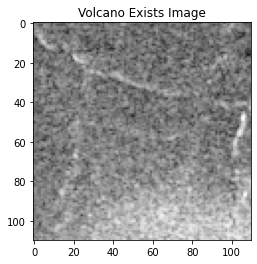

In [ ]:
# no volcano image
image = np.array(train_images.iloc[0]).reshape((110,110))
plt.imshow(image,cmap='gray')
plt.title('No Volcano Exists Image')
plt.show()

* So our images mostly have 1 volcano per image and 3rd type should be expected the most following up with 4th type. 
Considering that 3 and 4 corresponds to 'Possibly Volcano' and 'Only Pit Visible', we can say that the images are hardly informative. 
* Pixel resolution and the amount of noise is also a challenge, that will push the limits of my feature extraction.
* As we've seen on the upper plots, our first  (volcano) and second (type) target columns has imbalance, it's definitely not a normal distrubituon and '0' no volcano class has way big cumulation than '1'.

* Considering the imbalance foudn through data analysis I'll be careful not to pay huge attention to accuracy but precision, recall and f1 score (the most to f1 since its the harmonic mean of recall and precision trade-off)

Data Analysis is finished, we've discovered mostly the distribution of classes.
I now have an idea of why my model could be behaving in a certain manner

# Data Pre-Processing

I could've add copies of instances from the under-represented classes, do over-sampling or I can delete instances from the over-represented class, under-sample them.
But I'll follow up with ImageDataGenerator augmentation technique in the following cells.

In [ ]:
# Prepare the input data for machine learning models
X_train =  train_images.values / 255
X_test = test_images.values / 255

# train_labels.fillna(value='nan',inplace=True)
# test_labels.fillna(value='nan',inplace=True)

y_train = train_labels["volcano"].values
y_test = test_labels["volcano"].values

X_up, y_up = resample(
    X_train[y_train == 1], y_train[y_train == 1], 
    replace=True,
    n_samples=X_train[y_train == 0].shape[0], 
    random_state=28)

X_train_upsampled = np.vstack((X_train[y_train == 0], X_up))
y_train_upsampled = np.hstack((y_train[y_train == 0], y_up))

y_pred = np.zeros(y_train_upsampled.shape[0])

In [ ]:
# Prepare the input data for deep learning models
img_rows, img_cols = 110, 110

# train_labels.fillna(value='nan',inplace=True)
# test_labels.fillna(value='nan',inplace=True)

Xtrain_raw = train_images/255
ytrain_raw = train_labels['volcano']
Xtest_raw = test_images/255
ytest_raw = test_labels['volcano']

X = Xtrain_raw.values.reshape((-1, img_rows, img_cols, 1))
y = ytrain_raw.values

X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size = 0.2, random_state = 3)

X_test = Xtest_raw.values.reshape((-1, img_rows, img_cols, 1))
y_test = ytest_raw.values

In [ ]:
import shutil

def copy_images(idx_list, src_folder_path, dest_folder_path):
  os.makedirs(os.path.dirname(dest_folder_path), exist_ok=True)

  for i in idx_list:
    shutil.copyfile(src_folder_path + str(i).zfill(4) + '.png', dest_folder_path + str(i).zfill(4) + '.png')

In [ ]:
train_pic_idx = train_labels.index[train_labels['volcano'] == 1].tolist()
copy_images(train_pic_idx, train_images_path, '/content/train_images_gen/volcano/')

train_no_volcano_idx = train_labels.index[train_labels['volcano'] == 0].tolist()
copy_images(train_no_volcano_idx, train_images_path, '/content/train_images_gen/no_volcano/')

test_volcano_idx = test_labels.index[test_labels['volcano'] ==1].tolist()
copy_images(test_volcano_idx, test_images_path, '/content/test_images_gen/volcano/')

test_no_volcano_idx = test_labels.index[test_labels['volcano'] == 0].tolist()
copy_images(test_no_volcano_idx, test_images_path, '/content/test_images_gen/no_volcano/')

In [ ]:
# Apply data augmentation
from keras.preprocessing.image import ImageDataGenerator

target_size = (110, 110)

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        '/content/train_images_gen/',
        target_size=target_size,
        batch_size=700,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        '/content/test_images_gen/',
        target_size=target_size,
        batch_size=100,
        class_mode='binary')

Found 7000 images belonging to 2 classes.
Found 2734 images belonging to 2 classes.


In [ ]:
train_datagen

In [ ]:
# shutil.make_archive('train_images_gen', 'zip', '/content/train_images_gen/')
# shutil.make_archive('test_images_gen', 'zip', '/content/test_images_gen/')

# Modelling

# Model 1: Volcano Classification

## Machine Learning Models

In [ ]:
def try_model(model_name, model, X_train, y_train, X_test, y_test):
  cross_val_scr = cross_val_score(estimator=model, 
                                  X=X_train, 
                                  y=y_train,
                                  cv=KFold(n_splits=10, shuffle=True, random_state=28),
                                  scoring='accuracy', 
                                  n_jobs=1)
 
  model.fit(X_train, y_train)
  preds = model.predict(X_test)
  return {
      'model_name': model_name,
      'precision': metrics.precision_score(y_test, preds),
      'recall': metrics.recall_score(y_test, preds),
      'f1_score': metrics.f1_score(y_test, preds),
      'mean_train_acc': np.mean(cross_val_scr),
      'std_train_acc': metrics.accuracy_score(y_test, preds),
      'test_acc': metrics.accuracy_score(y_test, preds),
      'conf_matrix': metrics.confusion_matrix(y_test, preds),
      'cross_val_scores': cross_val_scr,
      'classification_report': metrics.classification_report(y_test, preds)
  }

In [ ]:
def print_ml_results(results_dict):
  conf_matrix = results_dict.pop('conf_matrix')
  cross_val = list(results_dict.pop('cross_val_scores'))
  cls_report = results_dict.pop('classification_report')

  print('### Model name: ', results_dict.get('model_name').upper(), ' ###')
  for param, value in results_dict.items():
    print(f"{param}: {value}")
  print('\nCross validation scores: ', cross_val)
  print('\nClassification report:\n', cls_report)
  
  fig, ax = plt.subplots(figsize=(2, 2))
  ax.matshow(conf_matrix, cmap=plt.cm.RdPu, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i, s=conf_matrix[i, j], va="center", ha="center")
  plt.xlabel("predicted")
  plt.ylabel("actual")
  plt.show()

### Model name:  LOGISTIC REGRESSION  ###
model_name: Logistic Regression
precision: 0.14446952595936793
recall: 0.14746543778801843
f1_score: 0.1459521094640821
mean_train_acc: 0.8825
std_train_acc: 0.7260424286759327
test_acc: 0.7260424286759327

Cross validation scores:  [0.86, 0.8933333333333333, 0.8966666666666666, 0.9025, 0.8925, 0.8716666666666667, 0.8791666666666667, 0.88, 0.88, 0.8691666666666666]

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      2300
           1       0.14      0.15      0.15       434

    accuracy                           0.73      2734
   macro avg       0.49      0.49      0.49      2734
weighted avg       0.73      0.73      0.73      2734



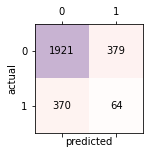

In [ ]:
from sklearn.linear_model import LogisticRegression

# LogisticRegression
lr_results = try_model('Logistic Regression', LogisticRegression(), X_train_upsampled, y_train_upsampled, X_test, y_test)
print_ml_results(lr_results)

In [ ]:
# from sklearn.svm import SVC

# # SVM
# svm_results = try_model('SVM', SVC(), X_train_upsampled, y_train_upsampled, X_test, y_test)
# print_ml_results(svm_results)

### Model name:  DECISION TREE  ###
model_name: Decision Tree
precision: 0.15225563909774437
recall: 0.18663594470046083
f1_score: 0.16770186335403728
mean_train_acc: 0.8756666666666668
std_train_acc: 0.7059253840526701
test_acc: 0.7059253840526701

Cross validation scores:  [0.8775, 0.8633333333333333, 0.8816666666666667, 0.9025, 0.8833333333333333, 0.8641666666666666, 0.8608333333333333, 0.8775, 0.8833333333333333, 0.8625]

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      2300
           1       0.15      0.19      0.17       434

    accuracy                           0.71      2734
   macro avg       0.50      0.50      0.49      2734
weighted avg       0.73      0.71      0.72      2734



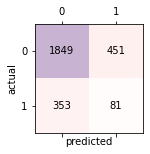

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# DecisionTreeClassifier
dt_results = try_model('Decision Tree', DecisionTreeClassifier(), X_train_upsampled, y_train_upsampled, X_test, y_test)
print_ml_results(dt_results)

Even though support is not uniformly distributed, we observed that our model is okay to predict True Positives while its terrible at True Negatives.
Also theres unacceptable amount of false predictions

### Model name:  RANDOM FOREST  ###
model_name: Random Forest
precision: 0.14453125
recall: 0.08525345622119816
f1_score: 0.1072463768115942
mean_train_acc: 0.9330833333333333
std_train_acc: 0.7746891002194587
test_acc: 0.7746891002194587

Cross validation scores:  [0.9383333333333334, 0.9408333333333333, 0.9383333333333334, 0.95, 0.9333333333333333, 0.9258333333333333, 0.9141666666666667, 0.935, 0.9333333333333333, 0.9216666666666666]

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      2300
           1       0.14      0.09      0.11       434

    accuracy                           0.77      2734
   macro avg       0.49      0.50      0.49      2734
weighted avg       0.73      0.77      0.75      2734



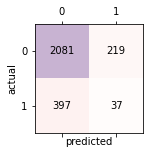

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# RandomForest
rf_results = try_model('Random Forest', RandomForestClassifier(), X_train_upsampled, y_train_upsampled, X_test, y_test)
print_ml_results(rf_results)

our model is relatively good at predicting positives while its terrible at predicting negatives

### Model name:  KNN  ###
model_name: KNN
precision: 0.149439601494396
recall: 0.2764976958525346
f1_score: 0.19401778496362165
mean_train_acc: 0.8073333333333335
std_train_acc: 0.6353328456474031
test_acc: 0.6353328456474031

Cross validation scores:  [0.8108333333333333, 0.8025, 0.795, 0.8391666666666666, 0.8158333333333333, 0.8, 0.7925, 0.815, 0.8183333333333334, 0.7841666666666667]

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.70      0.76      2300
           1       0.15      0.28      0.19       434

    accuracy                           0.64      2734
   macro avg       0.49      0.49      0.48      2734
weighted avg       0.73      0.64      0.67      2734



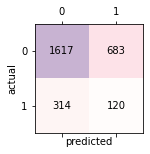

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# KNN
knn_results = try_model('KNN', KNeighborsClassifier(), X_train_upsampled, y_train_upsampled, X_test, y_test)
print_ml_results(knn_results)

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier

# # XGBoost
# xg_results = try_model('Gradient Boosting Classifier', GradientBoostingClassifier(), X_train_upsampled, y_train_upsampled, X_test, y_test)
# print_ml_results(xg_results)

In [ ]:
model_results = [lr_results, 
                 # svm_results, 
                 dt_results, 
                 rf_results, 
                 knn_results, 
                 #xg_results
                 ]

df_dict = {}
for key in lr_results.keys():
  df_dict[key] = [r[key] for r in model_results]

ml_model_results = pd.DataFrame(df_dict).set_index('model_name').sort_values('mean_train_acc', ascending=False)

In [ ]:
ml_model_results

,precision,recall,f1_score,mean_train_acc,std_train_acc,test_acc
model_name,,,,,,
Random Forest,0.144531,0.085253,0.107246,0.933083,0.774689,0.774689
Logistic Regression,0.144470,0.147465,0.145952,0.882500,0.726042,0.726042
Decision Tree,0.152256,0.186636,0.167702,0.875667,0.705925,0.705925
KNN,0.149440,0.276498,0.194018,0.807333,0.635333,0.635333


In [ ]:
ml_model_results.to_csv('ml_model_results.csv')

## Deep Learning Models

In [ ]:
# result graphics
def print_dl_results(history):
  fig, ax = plt.subplots(1,2, figsize = (14,6))
  ax[0].plot(history.epoch, history.history['loss'], color='b', label="Training loss")
  ax[0].plot(history.epoch, history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
  ax[0].legend(loc='best', shadow=True)
  ax[0].set_title('loss vs epoch')

  ax[1].plot(history.epoch, history.history['accuracy'], color='b', label="Training accuracy")
  ax[1].plot(history.epoch, history.history['val_accuracy'], color='r',label="Validation accuracy")
  ax[1].legend(loc='best', shadow=True)

In [ ]:
callBack = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto')

### CNN

In [ ]:
cnn_model1 = tf.keras.models.Sequential([
    # first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(img_rows, img_cols, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 108, 108, 16)      160       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 64)      

In [ ]:
cnn_model1.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              # optimizer=RMSprop(learning_rate=1e-4),
              metrics=["accuracy"])  

In [ ]:
# Train the model
history = cnn_model1.fit(
  X_train, y_train, 
  epochs=100,
  verbose=1,
  validation_data=(X_vali, y_vali),
  batch_size=700,
  callbacks=[callBack])

Epoch 1/100
8/8 [==============================] - 12s 187ms/step - loss: 0.5588 - accuracy: 0.7721 - val_loss: 0.4724 - val_accuracy: 0.8564
Epoch 2/100
8/8 [==============================] - 1s 156ms/step - loss: 0.4384 - accuracy: 0.8573 - val_loss: 0.4314 - val_accuracy: 0.8564
Epoch 3/100
8/8 [==============================] - 1s 159ms/step - loss: 0.4190 - accuracy: 0.8573 - val_loss: 0.4197 - val_accuracy: 0.8564
Epoch 4/100
8/8 [==============================] - 1s 161ms/step - loss: 0.4133 - accuracy: 0.8573 - val_loss: 0.4151 - val_accuracy: 0.8564
Epoch 5/100
8/8 [==============================] - 1s 159ms/step - loss: 0.4124 - accuracy: 0.8573 - val_loss: 0.4142 - val_accuracy: 0.8564
Epoch 6/100
8/8 [==============================] - 1s 158ms/step - loss: 0.4115 - accuracy: 0.8573 - val_loss: 0.4156 - val_accuracy: 0.8564
Epoch 7/100
8/8 [==============================] - 1s 158ms/step - loss: 0.4122 - accuracy: 0.8573 - val_loss: 0.4161 - val_accuracy: 0.8564
Epoch 8/100


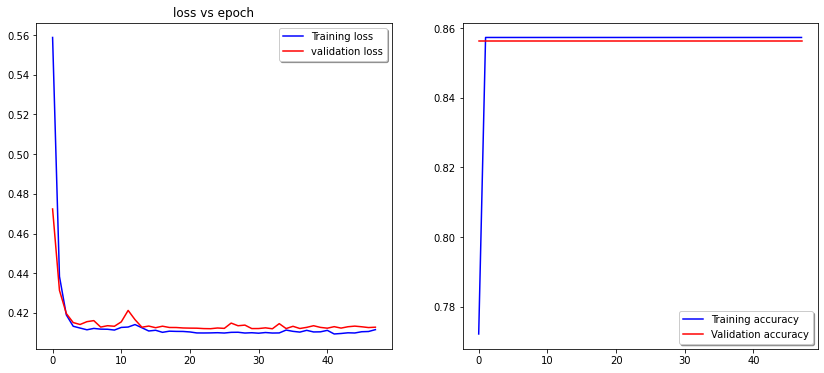

In [ ]:
print_dl_results(history)

In [ ]:
scores = cnn_model1.evaluate(X_train, y_train, verbose=1)
print(f"test loss: {scores[0]}, \ntest acc: {scores[1]}")

175/175 [==============================] - 1s 5ms/step - loss: 0.4087 - accuracy: 0.8573
test loss: 0.40868818759918213, 
test acc: 0.8573214411735535


### CNN with Dropouts

In [ ]:
cnn_model2 = tf.keras.models.Sequential([
    # first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(img_rows, img_cols, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 108, 108, 16)      160       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 26, 26, 32)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 26, 26, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 64)       

In [ ]:
cnn_model2.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              # optimizer=RMSprop(learning_rate=1e-4),
              metrics=["accuracy"])  

In [ ]:
# Train the model
history = cnn_model2.fit(
  X_train, y_train, 
  epochs=100,
  verbose=1,
  validation_data=(X_vali, y_vali),
  batch_size=700,
  callbacks=[callBack])

Epoch 1/100
8/8 [==============================] - 2s 185ms/step - loss: 0.5348 - accuracy: 0.8082 - val_loss: 0.4535 - val_accuracy: 0.8564
Epoch 2/100
8/8 [==============================] - 1s 160ms/step - loss: 0.4433 - accuracy: 0.8573 - val_loss: 0.5388 - val_accuracy: 0.8564
Epoch 3/100
8/8 [==============================] - 1s 162ms/step - loss: 0.4259 - accuracy: 0.8573 - val_loss: 0.4725 - val_accuracy: 0.8564
Epoch 4/100
8/8 [==============================] - 1s 160ms/step - loss: 0.4242 - accuracy: 0.8573 - val_loss: 0.4910 - val_accuracy: 0.8564
Epoch 5/100
8/8 [==============================] - 1s 161ms/step - loss: 0.4163 - accuracy: 0.8573 - val_loss: 0.4717 - val_accuracy: 0.8564
Epoch 6/100
8/8 [==============================] - 1s 160ms/step - loss: 0.4140 - accuracy: 0.8573 - val_loss: 0.4754 - val_accuracy: 0.8564
Epoch 7/100
8/8 [==============================] - 1s 161ms/step - loss: 0.4129 - accuracy: 0.8573 - val_loss: 0.4747 - val_accuracy: 0.8564
Epoch 8/100
8

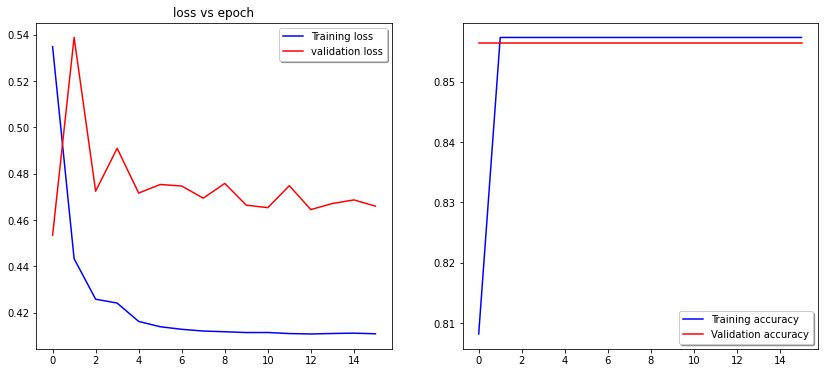

In [ ]:
print_dl_results(history)

In [ ]:
scores = cnn_model2.evaluate(X_train, y_train, verbose=1)
print(f"test loss: {scores[0]}, \ntest acc: {scores[1]}")

175/175 [==============================] - 1s 5ms/step - loss: 0.4651 - accuracy: 0.8573
test loss: 0.46514588594436646, 
test acc: 0.8573214411735535


### Transfer Learning

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D

from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

pre_trained_model = VGG16(input_shape=(110, 110, 3), include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

tf_model = Model(pre_trained_model.input, x)

tf_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

tf_model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 110, 110, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 110, 110, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 110, 110, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 55, 55, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 55, 55, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 55, 55, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 27, 27, 128)       0   

In [ ]:
trained_model = tf_model.fit_generator(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=test_images.shape[0]//100,
    steps_per_epoch=train_images.shape[0]//700)

Epoch 1/5
10/10 [==============================] - 44s 3s/step - loss: 0.6191 - accuracy: 0.6601 - val_loss: 0.5061 - val_accuracy: 0.8411
Epoch 2/5
10/10 [==============================] - 26s 3s/step - loss: 0.4827 - accuracy: 0.8219 - val_loss: 0.4471 - val_accuracy: 0.8404
Epoch 3/5
10/10 [==============================] - 27s 3s/step - loss: 0.4434 - accuracy: 0.8540 - val_loss: 0.4497 - val_accuracy: 0.8411
Epoch 4/5
10/10 [==============================] - 26s 3s/step - loss: 0.4430 - accuracy: 0.8563 - val_loss: 0.4543 - val_accuracy: 0.8407
Epoch 5/5
10/10 [==============================] - 26s 3s/step - loss: 0.4385 - accuracy: 0.8570 - val_loss: 0.4524 - val_accuracy: 0.8404


In [ ]:
def model_results(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy Score')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['Train', 'Validation'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss Score')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['Train', 'Validation'], loc='best')
    plt.show()

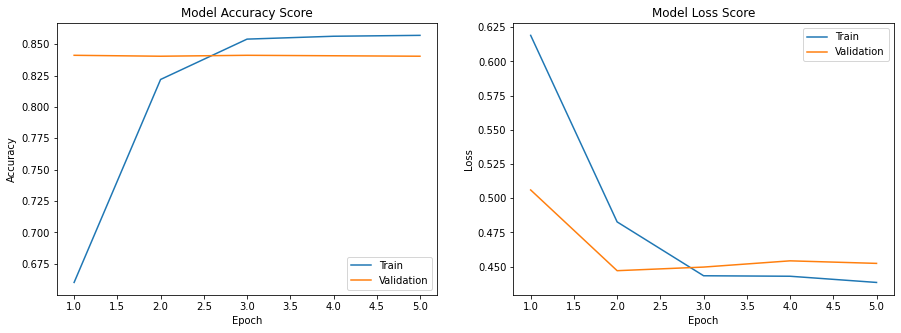

In [ ]:
model_results(trained_model)

# Model 2: Volcano Type Classification

In [ ]:
train_labels.fillna(value=0,inplace=True)
test_labels.fillna(value=0,inplace=True)

Xtrain_typ = np.array(train_images)
ytrain_typ = np.array(train_labels.drop(['radius'], 1))

Xtest_typ = np.array(test_images)
ytest_typ = np.array(test_labels.drop(['radius'], 1))

In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(Xtrain_typ, ytrain_typ)

pred = decision_tree.predict(Xtest_typ)
pred_decision_tree = pd.DataFrame(pred)
pred_decision_tree.columns = ['volcano','type','nvolcano']
print(pred_decision_tree.head())

   volcano  type  nvolcano
0      0.0   0.0       0.0
1      0.0   0.0       0.0
2      0.0   0.0       0.0
3      0.0   0.0       0.0
4      0.0   0.0       0.0


In [ ]:
from sklearn.linear_model import Lasso

radius_train_data = train_images[(train_labels['volcano'] == 1)].join(train_labels[(train_labels['volcano'] == 1)].drop(['radius','volcano'],1))
radius_train_labels = train_labels['radius'][(train_labels['volcano'] == 1)]

radius_test_data = test_images[(pred_decision_tree['volcano'] == 1)].join(pred_decision_tree[(pred_decision_tree['volcano'] == 1)].drop(['volcano'],1))
radius_test_labels = test_labels['radius'][(pred_decision_tree['volcano'] == 1)]

X_train = np.array(radius_train_data)
y_train = np.array(radius_train_labels)

X_test = np.array(radius_test_data)
y_test = np.array(radius_test_labels)

radius_regression = Lasso()
radius_regression.fit(X_train, y_train)

pred_rad = radius_regression.predict(X_test)
pred_radius_regression = pd.DataFrame(pred_rad)
pred_radius_regression.columns = ['radius']
print(pred_radius_regression.head())

      radius
0  12.866066
1  14.287156
2  15.358264
3  17.303475
4  16.890458


In [ ]:
pred_radius = []
y = 0
for x in range(pred_decision_tree.shape[0]):
    if pred_decision_tree['volcano'].iloc[x] == 1.0:
        pred_radius.append(pred_radius_regression['radius'].iloc[y])
        y+=1
    else:
        pred_radius.append(0.)

pred_radius = pd.DataFrame({'radius': pred_radius})
total_pred = pred_decision_tree.join(pred_radius)

cols = ['volcano','type','radius','nvolcano']
total_pred = total_pred[cols]
print(total_pred)

      volcano  type    radius  nvolcano
0         0.0   0.0   0.00000       0.0
1         0.0   0.0   0.00000       0.0
2         0.0   0.0   0.00000       0.0
3         0.0   0.0   0.00000       0.0
4         0.0   0.0   0.00000       0.0
...       ...   ...       ...       ...
2729      1.0   1.0  29.22133       1.0
2730      0.0   0.0   0.00000       0.0
2731      0.0   0.0   0.00000       0.0
2732      0.0   0.0   0.00000       0.0
2733      0.0   0.0   0.00000       0.0

[2734 rows x 4 columns]


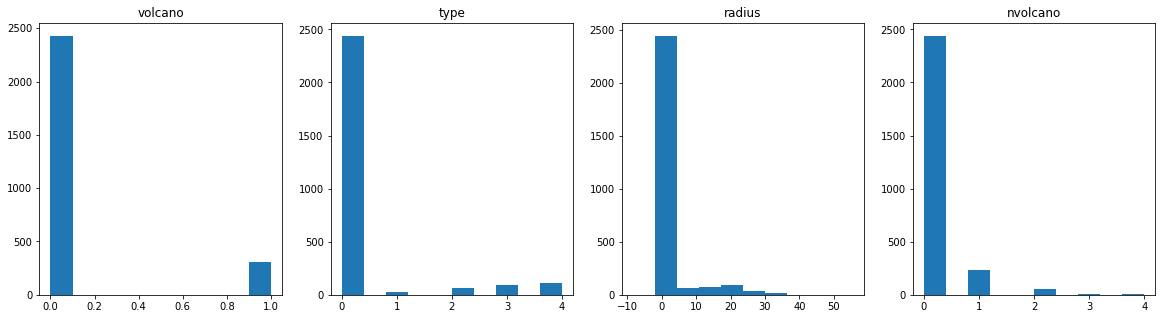

In [ ]:
i = 0
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for x in total_pred.keys():
    X = total_pred[x]
    axs[i].hist(X)
    axs[i].set_title(str(x))
    i += 1

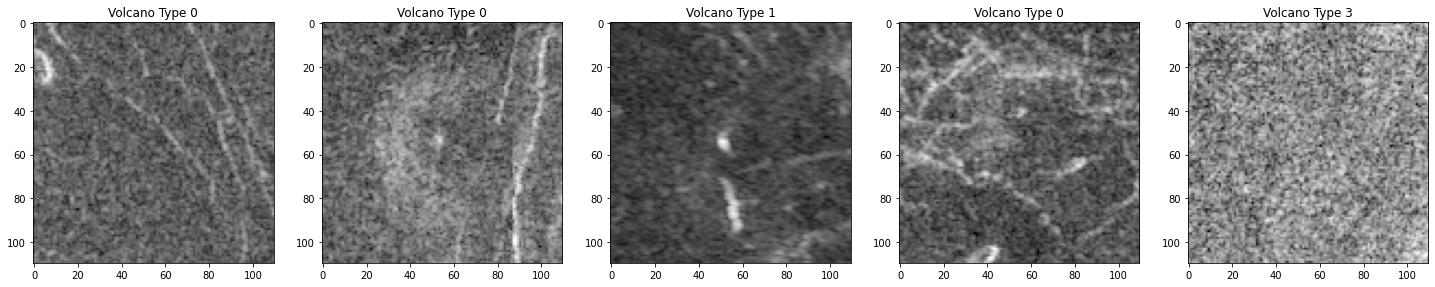

In [ ]:
# some samples of detected volcano types
detected = test_images[(total_pred['volcano'] == 1)].head()
fig, axs = plt.subplots(1, 5, figsize=(25, 25))
i = 0
for x in range(detected.shape[0]):
    image_flat = np.array(detected.iloc[x])
    image = image_flat.reshape((110,110))
    typ = test_labels.iloc[x]['type']
    axs[i].imshow(image,cmap='gray')
    axs[i].set_title('Volcano Type ' + str(int(typ)))
    i += 1

# Final Evaluation Results

A Volcano indicates life risk ➡️ A volcano shoulndn't be dismissed.
I have no excuses to a FN, when positive means volcano.
for that reason I'll focus on Recall metric very carefully, less FN means high recall so I want to observe a high recall on my evaluations.

I'll also focus on f1 score in order to keep an eye on my FP's too, which could cost too much to always misalert people for a volcano.